# Sklearn bunch visualizer

A simple visualizer for sklearn Bunch datasets.

It visualizes:

* Best ratio for test/validation data by performing NearestNeighbors algorytm with minkowski's metric
* How samples are spreaded
* PCA

In [81]:
from multiprocessing import Process, Queue
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import *
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import Bunch

from samples import Samples, Sample

def nn(item: Sample, data: List[Sample]) -> Tuple[float, str]:
    nbps: NearestNeighbors = NearestNeighbors(n_neighbors=1).fit([sample.get_attributes() for sample in data])
    distance, sample_index = nbps.kneighbors([item.get_attributes()])
    return distance[0][0], data[sample_index[0][0]].get_class_name(),

def error_test(test_data: List[Sample], validation_data: List[Sample]) -> float:
    errors = 0
    for item in test_data:
        distance, class_name = nn(item, validation_data)
        if class_name != item.get_class_name():
            errors += 1
    try:
        return 100 * float(errors) / len(test_data)
    except ZeroDivisionError:
        return 0.0

def compute_errors(ratio: int, queue: Queue):
    test_data, validation_data = samples.get_test_data(ratio)
    return queue.put((ratio, error_test(test_data, validation_data)))


### Here you can choose which dataset you'd like to load.
This algorytm was tested with iris, digits, and diabetes data.

In [82]:
#samples: Samples = Samples.load_from_bunch(load_iris())
#samples: Samples = Samples.load_from_bunch(load_diabetes())
samples: Samples = Samples.load_from_bunch(load_digits())


In [83]:
samples.print_details()

print("Details of first sample: ")
print(samples.get_all_samples()[0])
for class_name in samples.get_classes():
    samples.print_class_details(class_name)


Has 10 classes, with total of 1797 samples
Details of first sample: 
0 - 0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 13.0, 15.0, 10.0, 15.0, 5.0, 0.0, 0.0, 3.0, 15.0, 2.0, 0.0, 11.0, 8.0, 0.0, 0.0, 4.0, 12.0, 0.0, 0.0, 8.0, 8.0, 0.0, 0.0, 5.0, 8.0, 0.0, 0.0, 9.0, 8.0, 0.0, 0.0, 4.0, 11.0, 0.0, 1.0, 12.0, 7.0, 0.0, 0.0, 2.0, 14.0, 5.0, 10.0, 12.0, 0.0, 0.0, 0.0, 0.0, 6.0, 13.0, 10.0, 0.0, 0.0, 0.0
Class 0 has 178 samples
Class 1 has 182 samples
Class 2 has 177 samples
Class 3 has 183 samples
Class 4 has 181 samples
Class 5 has 182 samples
Class 6 has 181 samples
Class 7 has 179 samples
Class 8 has 174 samples
Class 9 has 180 samples


## Visualization of best ratio for test/validation data

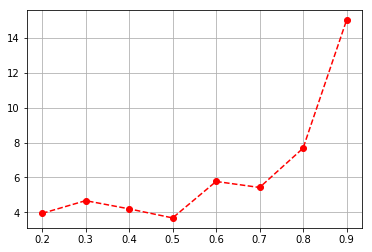

Best ration is 0.5 with error probability: 3.6830357142857144


In [84]:
output = Queue()
processes = [Process(target=compute_errors, args=(ratio, output,)) for ratio in np.linspace(0, 1, 11)[2:-1]]
for p in processes:
    p.start()
all_ratios = sorted([output.get() for p in processes], key=lambda k: k[0])
best_ratio = min(all_ratios, key=lambda ratio: ratio[1])
plt.plot([i[0] for i in all_ratios], [i[1] for i in all_ratios], 'ro--')
plt.grid(True)
plt.show()

print("Best ration is %s with error probability: %s" % (best_ratio[0], best_ratio[1]))


## Visualization of data spread

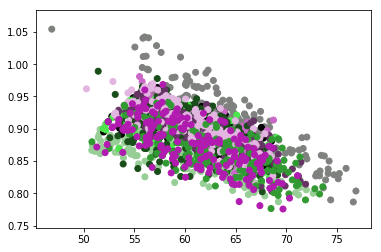

In [85]:
samples.visualize()


## PCA

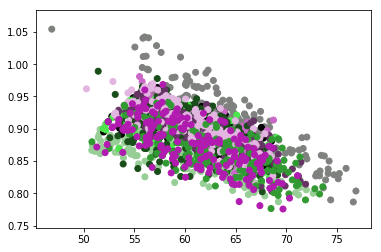

PCA with 64 attributes


Error test: 3.6830357142857144


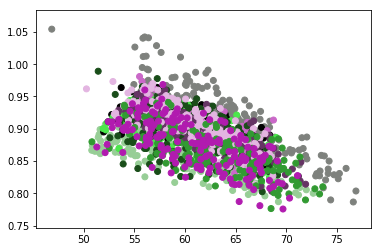

PCA with 63 attributes


Error test: 3.5714285714285716


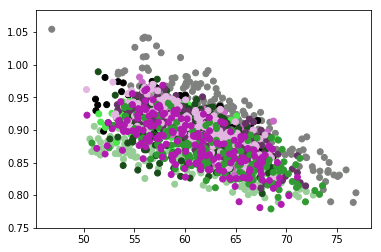

PCA with 62 attributes


Error test: 3.4598214285714284


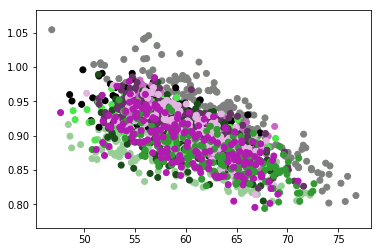

PCA with 61 attributes


Error test: 3.5714285714285716


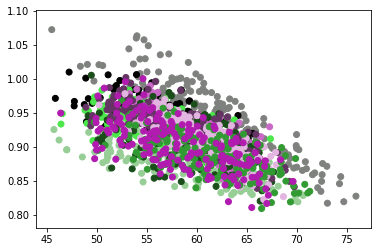

PCA with 60 attributes


Error test: 3.4598214285714284


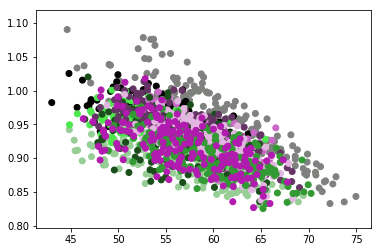

PCA with 59 attributes


Error test: 3.6830357142857144


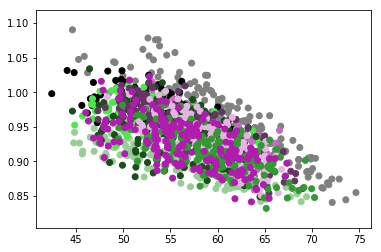

PCA with 58 attributes


Error test: 3.5714285714285716


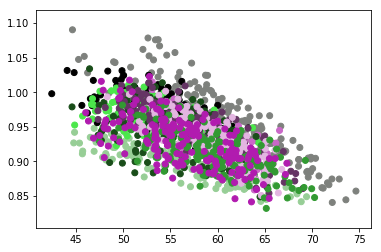

PCA with 57 attributes


Error test: 3.5714285714285716


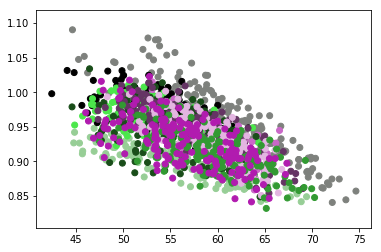

PCA with 56 attributes


Error test: 3.5714285714285716


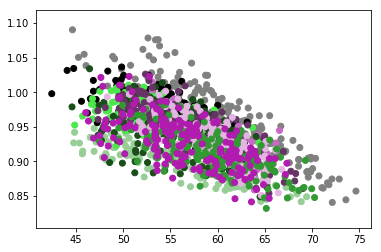

PCA with 55 attributes


Error test: 3.6830357142857144


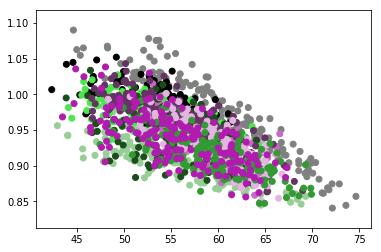

PCA with 54 attributes


Error test: 3.794642857142857


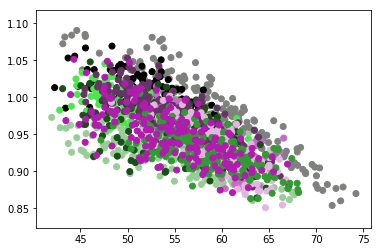

PCA with 53 attributes


Error test: 4.129464285714286


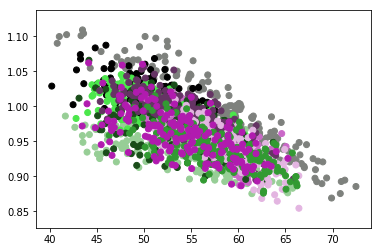

PCA with 52 attributes


Error test: 4.464285714285714


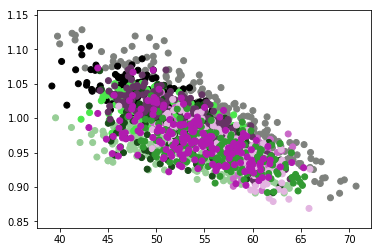

PCA with 51 attributes


Error test: 5.133928571428571


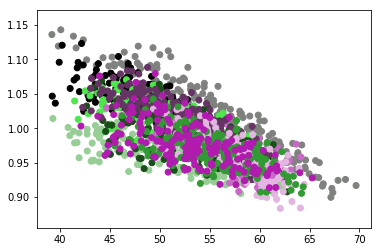

PCA with 50 attributes


Error test: 5.357142857142857


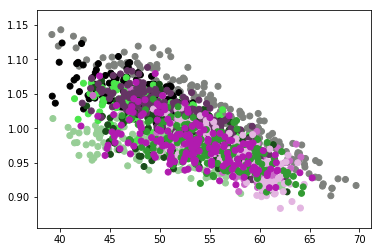

PCA with 49 attributes


Error test: 5.46875


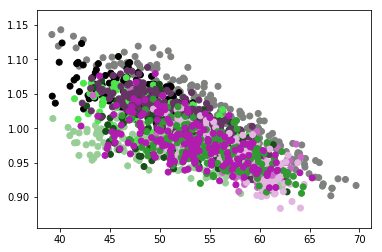

PCA with 48 attributes


Error test: 5.46875


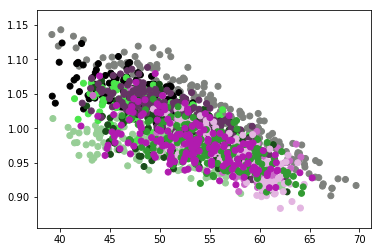

PCA with 47 attributes


In [86]:
attributes_count = len(samples.get_all_samples()[0].get_attributes())
for pca_attributes in range(len(samples.get_all_samples()[0].get_attributes()), 1, -1):
    pca_sample_list: List[Sample] = []
    for sample in samples.get_all_samples():
        attrs = list(sample.get_attributes()[:pca_attributes])
        attrs.extend([0 for i in range(attributes_count - pca_attributes)])
        pca_sample = Sample(sample.get_class_name(), sample.get_attribute_names(), attrs)
        pca_sample_list.append(pca_sample)
    pca_samples: Samples = Samples(pca_sample_list)
    pca_samples.visualize()
    test_data, validation_data = pca_samples.get_test_data(best_ratio[0])
    print("PCA with %s attributes" % pca_attributes)
    print("Error test: %s" % error_test(test_data, validation_data))
